# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Library Imports

In [160]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import os
import itertools
from time import time

import pickle

import enum
# magic word for producing visualizations in notebook
%matplotlib inline

pd.set_option('display.max_rows', None)

## Directory Setup

In [161]:
analysis_dir = './analysis'
dataset_dir = './datasets'

for new_dir in analysis_dir,dataset_dir:
    try:
        os.mkdir(new_dir)
        print("made new directory: {0}".format(new_dir))
    except FileExistsError:
        print("{0} already exists".format(new_dir))

./analysis already exists
./datasets already exists


In [162]:
for new_dir in analysis_dir,dataset_dir:
    try:
        print("hello")
    except:
        pass

hello
hello


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [163]:
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';')

C:\Users\Olive\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [164]:
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=';')
mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [165]:
for df in (azdias,customers,mailout_train):
    print(df.shape)

(891221, 366)
(191652, 369)
(42962, 367)


## Part 0: Initial Discussion of my Plan

In this first section I am going to prepare the azdias dataset ready for the Customer Segmentation Report section.

These are high dimensionality datasets so before model the data using an unsupervised learning model I am first going to want to reduce the dimensionality.

To do this I am going to use Principle Component Analysis (PCA) which will transform the dataset into its principle variant components. PCA is a continuous feature method that is performed on centred and normalised data.

Therefore prior to peforming PCA I first need to have a dataset that is made up of numerical, normalised data with no missing values.

My overall strategy for creating this clean dataset is as follows.

* Convert any categorical variables to continuous numerical variables
* Determine a strategy for handling missing values
* Normalise all numerical 

There are a number of additional considerations in these steps that is worth discussing before proceeding.

### Normalising numerical features

It would seem obvious, but all numerical features should have a clear ranking. i.e. for the given feature each incremental or decremental value represents an increase or decrease.

e.g.

1 = Low
2 = Med
3 = High

or 

1 = High
2 = Med
3 = High

If however a numerical feature doesn't have a clear ranking, i.e.

1 = Med
2 = Low
3 = High

Then when normalising this feature issues will arise with PCA. 

Bearing this in mind, I am going to take extra care to understand the the numerical variables and verify there is a rank ordering.

There are two essential documents supplied by Arvato to help with this:

DIAS Attributes - Values 2017
DIAS Information Levels - Attributes 2017

### Categorical features

Since categorical features need to be converted to ranked, numerical features the first question that arises is whether the categorical features is ordinal. If it is, then it should be a straightforward conversion.

It it is not ordinal then one-hot encoding could be considered. This should only be used if the feature is of low cardinality else this introduces sparse features into the dataset which will impact PCA.

### Missing values

Missing values will need to be handled.

One option is to drop rows that have missing values. This may seem a logical strategy if there are rows with lots of missing values, however this would assume that all features are of equal value: If a row is missing lots of low interest feature values but retains many high interest feature values then it may be fine to keep the row. The challenge there however is in discerning what would be considered a high interest feature. Some inferences could be made but this would be discretionary. Unfortunately we are not in contact with Arvato so no further clarity can be gained in understanding the collected features more.

Another option is to impute values. This could be better than dropping the rows since information is retained. However, it runs the risk of adding information that wasn't there.

In evaluating the missing values, the question to keep in mind is: Why are these values missing? 

Perhaps there was no suitable category or value for that individual for that feature. In which case, imputing a value is a dangerous strategy.

We don't know how this dataset was amalgamated. Perhaps if the dataset was joined from various subtables, NaN were introduced. In which case, imputing values could be an ok strategy. 

Additionally, imputing 'good' values can be computationally expensive using something like a knn imputer and right now I am resource limited.

I think my best strategy will be to remove rows where there are a significant number of missing values and do simple imputation on non-missing values.

### Conclusion

My first step is to refer to the DIAS documents and assess each feature. There are 366 features so I need to strike a balance between analysis and managing my project time. My main interest is in considering the points i've discussed above which are in summary:

* Are numerical features ranked?
* Are categorical features ordinal or low cardinality?
* Does anything else stand out about these features that might be worth keeping in mind?

The next section will be a discussion of these points.

# Part 0: Getting to know all 366 features

This section is going to be fairly hands-off with regards to specific analysis of the data within the dataset and is instead going to focus on understanding the features and the value they contribute, keeping in mind I intend to normalise all features in preparation for EDA.

Approaching it this way, I can save myself some time with EDA and later processing by dropping any features that I do not consider good.

I am now going to proceed through the DIAS sheets and analyse each feature. By the end of this section I aim to have a cleaner dataset that I can move forward with, with some Exploratory Data Analysis.

This section will be broken down into a discussion of observations with some actions points at the end.

### Discussion

I note many of the features that are numerical have a numerical value that signifies the information is 'unknown'. This can be thought of as a known 'uknown' unlike a NaN which would be an uknown 'uknown'. Often the value is 0 or -1, although sometimes it is the max value depending on how the feature is ranked.

For example: 

*D19_GESAMT_ONLINE_DATUM, ranks from highest=0 - lowest=9. uknown=10
*BALLRAUM - ranks from lowest=1 - highest=7. unknown=0

This is quite problematic for normalising the data because the uknown in effect means it could be any value but by positioning it as the lowest or highest numerical value gives meaning to where there is no meaning. This will distort the normalisation.

In addition, being a quantified uknown doesn't give us a sense of how populated these features actually are. Therefore, these uknown values should be addressed in the same way as NaN.

Some of the features are effectively Boolean, taking 1 of 2 values. e.g. gender, (east|west). I think min-max feature scaling will be appropriate for all these features with any known uknown values being centred at 0.

CAMEO_DEUINTIL_2015 - This is a perculiar ranked, numerical feature that seems to combine two categories:

Wealth i.e. Wealthy/Prosperous/Comfortable
Life stage i.e. Pre-Family/Young Couples/Families

The problem with this is that Life stage is conflated with wealth in the same rank. This feature should be split. I should check if any other features have this perculiarity.

There are some more perculiar features.

* D19_*_RZ

These 11 features describe transaction activity based on a product group with the following 8 categories:

0. no transaction known
1. Multibuyer 0-12 months
2. Doublebuyer 0-12 months
3. Singlebuyer 0-12 months
4. Multi/Doublebuyer 13-24 months
5. Singlebuyer 13-24 months
6. Buyer > 24 months
7. Prospects > 24 months

I feel these features could be split into two clearer categories however it is unclear to me the relationship between the first set of categories: (Multibuyer,Doublebuyer,Singlebuyer) and the second: (Buyer,Prospects). I can find no more information about these in the supplied information. 

I think I'm going to leave these features as they are since there is a general ranking structure.

TITEL_KZ is odd

-1. unknown
0. unknown
1. Dr.
2. Dr. Dr.
3. Prof.
4. Prof. Dr.
5. other

The description is: 'Flag whether this person holds an academic title'.

I don't understand what is meant by Dr and then Dr.Dr, though I think diffrentiating between holding an academic titles and not holding one is useful. I'm going to analyse this feature further. I think I could bin groups 1-5 and -1-0 and min-max scale them and this feature could then be a useful dimension in my PCA.

#### Action Points

After analysing both documents fully I have the following specific action breakdown.

Generally speaking, many of the features are ranked and numerical that will be easy to normalise. The quantifying of uknown values as a min or max is an issue however. These should be set to NaN and imputed.

In addition, I need to verify whether any features are present in the dataset that are missing from the information sheet. If I cannot discern the meaning or structure of these undocumented features then they will need to be dropped.

The following is a list of further actions for specific features.

##### Features to analyse further

* CJT_GESAMTTYP - Looks like it should be one-hot encoded, inspect further
* TITEL_KZ - Understand the distribution of values

##### Features to drop

* CAMEO_DEU_2015 - high cardinality, non-ordinal categorical

The following were numerical features that had no clear ranking. In effect, categorical features. These could be one-hot encoded but it was felt this would introduce sparse features into an already high dimensionality dataset. After evaluating their significance, it was decided they should be dropped.

* D19_KONSUMTYP
* GFK_URLAUBERTYP
* HAUSHALTSTRUKTUR
* KBA05_MAXHERST
* ZABEOTYP

##### Features to alter

* CAMEO_DEUINTIL_2015 - split into 2 features
* NATIONALITAET_KZ - One hot encode

##### Features to min-max scale

These are features that have only 2 values (notwithstanding NaN/uknown). One value will be assigned -1, the other value will be 1. The assignment choice is arbitrary.

* BIP_FLAG
* ANDREDE_KZ
* GREEN_AVANTGARDE
* OST_WEST_KZ
* SOHO_FLAG
* VERS_TYP

##### Next actions to take

* Determine which features were missing from the information sheet.
* Determine for each feature if it has an 'uknown/missing' value and what that value is. Not the same as 'not known'. Construct a table. If not min and max scaling, set uknown values to NaN for later imputation.
* Determine which features to Min-Max Scale



In [166]:
# Construct a new csv file for manual input using the DIAS information sheets on the features
feature_analysis_df = pd.DataFrame(columns=['feature','to_keep','notes'])
feature_analysis_df['feature'] = azdias.columns
print(feature_analysis_df.shape)

(366, 3)


In [167]:
feature_analysis_df.to_csv(analysis_dir+'/feature_analysis_df_template.csv',index=False)

In [168]:
azdias['D19_KONSUMTYP_MAX'].unique()

array([9, 8, 1, 2, 3, 4], dtype=int64)

In [169]:
azdias['D19_KONSUMTYP'].unique()

array([nan,  9.,  1.,  4.,  3.,  6.,  5.,  2.])

In [170]:
cols_to_drop_stage0 = [
    'CAMEO_DEU_2015',
    'GFK_URLAUBERTYP',
    'STRUKTURTYP', #HAUSHALTSTRUKTUR in DIAS
    'D19_KONSUMTYP_MAX', #D19_KONSUMTYP in Table
    'D19_KONSUMTYP',
    'KBA05_MAXHERST',
    'ZABEOTYP'
]

In [171]:
def check_cols_drop_added_to_feature_analysis_df(cols_drop):
    '''Check that the expected number of columns to drop
    have been added to the "feature_analysis_df.csv" file
    '''
    
    feature_analysis_df = pd.read_csv('./analysis/feature_analysis_df.csv',encoding = "cp1252")
    
    for col in cols_drop:
        assert_col_added(col,feature_analysis_df)
        assert_col_value_is_false(col,feature_analysis_df)
        
    print("All {0} features that should be dropped are listed correctly in: {1}".format(\
        len(cols_drop),'./analysis/feature_analysis_df.csv'))
    
def assert_col_added(col,feature_analysis_df):
    
    assert col in feature_analysis_df.feature.unique(),\
            "{0} not found in {1}".format(col,feature_analysis_df_name)

def assert_col_value_is_false(col,feature_analysis_df):
    
    assert feature_analysis_df.loc[feature_analysis_df.feature == col].to_keep.values == False,\
            "{0} does not have val set to False".format(col)

In [172]:
check_cols_drop_added_to_feature_analysis_df(cols_to_drop_stage0)

All 7 features that should be dropped are listed correctly in: ./analysis/feature_analysis_df.csv


## What features were missing from the DIAS Sheets?

Now that I have analysed all the features documented in the DIAS sheets, I need to cross reference this with the features in the dataset and find out if they are all accounted for.

To do this i'm going to try converting the .xlsx sheets to csv and reading in the list of 'attributes' and cross-referencing this with the feature list to see if there are any discrepancies.

In [173]:
DIAS_attr = pd.read_csv('./DIAS_Attributes_Values_2017.csv', sep=',',header=1)

In [174]:
DIAS_attr.shape

(2258, 5)

In [175]:
DIAS_attr.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


Going to remove whitespace from the column names and analyse this further.

It's important to note there are only 313 features here. Possibly some are condensed?

In [176]:
DIAS_attr = DIAS_attr.rename(columns={"Unnamed: 0":"U0"})
DIAS_attr.groupby("U0").U0.count()

Series([], Name: U0, dtype: int64)

In [177]:
attributes = DIAS_attr.groupby("Attribute").Attribute.count()
attributes

Attribute
AGER_TYP                       1
ALTERSKATEGORIE_GROB           1
ALTER_HH                       1
ANREDE_KZ                      1
ANZ_HAUSHALTE_AKTIV            1
ANZ_HH_TITEL                   1
ANZ_PERSONEN                   1
ANZ_TITEL                      1
BALLRAUM                       1
BIP_FLAG                       1
CAMEO_DEUG_2015                1
CAMEO_DEUINTL_2015             1
CAMEO_DEU_2015                 1
CJT_GESAMTTYP                  1
D19_BANKEN_ANZ_12              1
D19_BANKEN_ANZ_24              1
D19_BANKEN_DATUM               1
D19_BANKEN_DIREKT_RZ           1
D19_BANKEN_GROSS_RZ            1
D19_BANKEN_LOKAL_RZ            1
D19_BANKEN_OFFLINE_DATUM       1
D19_BANKEN_ONLINE_DATUM        1
D19_BANKEN_ONLINE_QUOTE_12     1
D19_BANKEN_REST_RZ             1
D19_BEKLEIDUNG_GEH_RZ          1
D19_BEKLEIDUNG_REST_RZ         1
D19_BILDUNG_RZ                 1
D19_BIO_OEKO_RZ                1
D19_BUCH_RZ                    1
D19_DIGIT_SERV_RZ              1


Some of these attributes need cleaning up. I now need to check if any have shifted column

In [178]:
DIAS_attr.groupby("Description").Description.count()

Description
 - on grid level -                                                                             34
'- classified number of inhabitants                                                             1
(each German CAMEO code belongs to one international code)                                      1
CAMEO classification 2015 - Uppergroup                                                          1
CAMEO classification 2015 - detailled classification                                            1
CAMEO classification 2015 - international typology                                              1
Green avantgarde                                                                                1
actuality of the last transaction for the segment banks OFFLINE                                 1
actuality of the last transaction for the segment banks ONLINE                                  1
actuality of the last transaction for the segment banks TOTAL                                   1
actualit

In [179]:
DIAS_attr.groupby("Meaning").Meaning.count()

Meaning
01.01.1895 bis 31.12.1899                                                                                                                                                   1
01.01.1900 bis 31.12.1904                                                                                                                                                   1
01.01.1905 bis 31.12.1909                                                                                                                                                   1
01.01.1910 bis 31.12.1914                                                                                                                                                   1
01.01.1915 bis 31.12.1919                                                                                                                                                   1
01.01.1920 bis 31.12.1924                                                                                                 

It looks like all the relevant information is contained in the attributes column. 

In [180]:
attributes = attributes.index
attributes

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'BALLRAUM', 'BIP_FLAG',
       ...
       'SEMIO_VERT', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 'VERS_TYP',
       'WACHSTUMSGEBIET_NB', 'WOHNDAUER_2008', 'WOHNLAGE', 'W_KEIT_KIND_HH',
       'ZABEOTYP'],
      dtype='object', name='Attribute', length=314)

In [181]:
attributes = ' '.join(attributes)
attributes = attributes.split(sep=' ')
attributes = list(filter(None,attributes))
attributes

['AGER_TYP',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'BALLRAUM',
 'BIP_FLAG',
 'CAMEO_DEUG_2015',
 'CAMEO_DEUINTL_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KONSUMTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITT

In [182]:
len(attributes)

314

In [183]:
attributes = list(set(attributes))
len(attributes)

314

In [184]:
only_azdias = [a for a in azdias.columns if a not in attributes]
only_dias = [a for a in attributes if a not in azdias.columns]

In [185]:
only_azdias.sort()
only_dias.sort()

In [186]:
print("Features Only in Azdias:{0}".format(len(only_azdias)))
print("Features Only in DIAS attributes:{0}".format(len(only_dias)))

Features Only in Azdias:94
Features Only in DIAS attributes:42


In [187]:
col_width = max(len(word) for word in only_azdias) + 2
print("Only in AZDIAS\t\t\t\t\tOnly in DIAS attributes\n")
for a,b in itertools.zip_longest(only_azdias,only_dias):
    a = "".join(a.ljust(col_width))
    print("{0}\t\t\t{1}".format(a,b))

Only in AZDIAS					Only in DIAS attributes

AKT_DAT_KL                  			BIP_FLAG
ALTERSKATEGORIE_FEIN        			CAMEO_DEUINTL_2015
ALTER_KIND1                 			D19_BANKEN_DIREKT_RZ
ALTER_KIND2                 			D19_BANKEN_GROSS_RZ
ALTER_KIND3                 			D19_BANKEN_LOKAL_RZ
ALTER_KIND4                 			D19_BANKEN_REST_RZ
ANZ_KINDER                  			D19_BEKLEIDUNG_GEH_RZ
ANZ_STATISTISCHE_HAUSHALTE  			D19_BEKLEIDUNG_REST_RZ
ARBEIT                      			D19_BILDUNG_RZ
CAMEO_INTL_2015             			D19_BIO_OEKO_RZ
CJT_KATALOGNUTZER           			D19_BUCH_RZ
CJT_TYP_1                   			D19_DIGIT_SERV_RZ
CJT_TYP_2                   			D19_DROGERIEARTIKEL_RZ
CJT_TYP_3                   			D19_ENERGIE_RZ
CJT_TYP_4                   			D19_FREIZEIT_RZ
CJT_TYP_5                   			D19_GARTEN_RZ
CJT_TYP_6                   			D19_HANDWERK_RZ
D19_BANKEN_DIREKT           			D19_HAUS_DEKO_RZ
D19_BANKEN_GROSS            			D19_KINDERARTIKEL_RZ
D19_BANKEN_LOKAL            			

Looks like alot of DIAS attributes have this RZ suffix. 

Note some useful to feedback to Arvato at this point would be improve their naming consistency across documents.

In [188]:
only_dias_no_rz = [a if not a.endswith('_RZ') else a[:-3] for a in only_dias]
only_azdias_stage1 = [a for a in only_azdias if a not in [*only_dias_no_rz,*cols_to_drop_stage0]]
only_dias_stage1 = [a for a in only_dias_no_rz if a not in [*only_azdias,*cols_to_drop_stage0]]

In [189]:
print("Features Only in Azdias:{0}".format(len(only_azdias_stage1)))
print("Features Only in DIAS attributes:{0}".format(len(only_dias_stage1)))

Features Only in Azdias:59
Features Only in DIAS attributes:9


In [190]:
col_width = max(len(word) for word in only_azdias_stage1) + 2
print("Only in AZDIAS\t\t\t\t\tOnly in DIAS attributes\n")
for a,b in itertools.zip_longest(only_azdias_stage1,only_dias_stage1):
    a = "".join(a.ljust(col_width))
    print("{0}\t\t\t{1}".format(a,b))

Only in AZDIAS					Only in DIAS attributes

AKT_DAT_KL                  			BIP_FLAG
ALTERSKATEGORIE_FEIN        			CAMEO_DEUINTL_2015
ALTER_KIND1                 			D19_BUCH
ALTER_KIND2                 			D19_KK_KUNDENTYP
ALTER_KIND3                 			GEOSCORE_KLS7
ALTER_KIND4                 			HAUSHALTSSTRUKTUR
ANZ_KINDER                  			KBA13_CCM_1400_2500
ANZ_STATISTISCHE_HAUSHALTE  			SOHO_FLAG
ARBEIT                      			WACHSTUMSGEBIET_NB
CAMEO_INTL_2015             			None
CJT_KATALOGNUTZER           			None
CJT_TYP_1                   			None
CJT_TYP_2                   			None
CJT_TYP_3                   			None
CJT_TYP_4                   			None
CJT_TYP_5                   			None
CJT_TYP_6                   			None
D19_BUCH_CD                 			None
D19_LETZTER_KAUF_BRANCHE    			None
D19_SOZIALES                			None
D19_TELKO_ONLINE_QUOTE_12   			None
D19_VERSI_DATUM             			None
D19_VERSI_OFFLINE_DATUM     			None
D19_VERSI_ONLINE_DATUM      			None
D1

So now I need to figure out which ones are truly missing and which features I can continue to use.

I'm going to focus on the features only in the DIAS attributes first, this is the 2nd column.

We already know some of the D19 features that note transactional activity. The categorising of these is consistent so these are fine to use

This is true of the KBA13 features also

### Remove following from only_azdias

The following have now been found:

* CAMEO_INTL_2015
* CJT_TYP1 - This refers to the DIAS CJT_GESAMTTYP
* CJT_TYP_2
* CJT_TYP_3
* CJT_TYP_4
* CJT_TYP_5
* CJT_TYP_6
* D19_BUCH_CD
* D19_KONSUMTYP_MAX
* D19_TELKO_ONLINE_QUOTE_12
* D19_VERSI_DATUM
* D19_SOZIALES
* D19_VERSI_OFFLINE_DATUM
* D19_VERSI_ONLINE_DATUM 
* D19_VERSI_ONLINE_QUOTE_12
* KBA13_ANTG1
* KBA13_ANTG2
* KBA13_ANTG3
* KBA13_ANTG4
* KBA13_BAUMAX
* KBA13_CCM_1401_2500
* KBA13_GBZ
* KBA13_HHZ
* KBA13_KMH_210
* KK_KUNDENTYP
* STRUKTURTYP - Refers to Haushaltstruktur

### Drop

D19_KONSUMTYP_MAX == D19_KONSUMPTYP. This feature was already determined to be dropped.

### Remove following from only_dias

The following have now been found:

* CAMEO_DEUINTL_2015
* D19_BUCH
* D19_KK_KUNDENTYP
* HAUSHALTSSTRUKTUR
* KBA13_CCM_1400_2500

The following have not been found:

* BIP_FLAG
* GEOSCORE_KLS7
* SOHO_FLAG
* WACHSTUMSGEBIET_NB
* D19_LETZTER_KAUF_BRANCHE

In [191]:
azdias_cols_now_analysed = ['CAMEO_INTL_2015',
    'CJT_TYP_1',
    'CJT_TYP_2',
    'CJT_TYP_3',
    'CJT_TYP_4',
    'CJT_TYP_5',
    'CJT_TYP_6',
    'D19_BUCH_CD',
    'D19_KONSUMTYP_MAX',
    'D19_TELKO_ONLINE_QUOTE_12',
    'D19_VERSI_DATUM',
    'D19_SOZIALES',
    'D19_VERSI_OFFLINE_DATUM',
    'D19_VERSI_ONLINE_DATUM',
    'D19_VERSI_ONLINE_QUOTE_12',
    'KBA13_ANTG1',
    'KBA13_ANTG2',
    'KBA13_ANTG3',
    'KBA13_ANTG4',
    'KBA13_BAUMAX',
    'KBA13_CCM_1401_2500',
    'KBA13_GBZ',
    'KBA13_HHZ',
    'KBA13_KMH_210',
    'KK_KUNDENTYP',
    'STRUKTURTYP']

In [192]:
only_azdias_stage2 = [a for a in only_azdias_stage1 if a not in azdias_cols_now_analysed]

In [193]:
print("number of uknown features:{0}".format(len(only_azdias_stage2)))
print("\n".join(only_azdias_stage2))

number of uknown features:35
AKT_DAT_KL
ALTERSKATEGORIE_FEIN
ALTER_KIND1
ALTER_KIND2
ALTER_KIND3
ALTER_KIND4
ANZ_KINDER
ANZ_STATISTISCHE_HAUSHALTE
ARBEIT
CJT_KATALOGNUTZER
D19_LETZTER_KAUF_BRANCHE
DSL_FLAG
EINGEFUEGT_AM
EINGEZOGENAM_HH_JAHR
EXTSEL992
FIRMENDICHTE
GEMEINDETYP
HH_DELTA_FLAG
KOMBIALTER
KONSUMZELLE
LNR
MOBI_RASTER
RT_KEIN_ANREIZ
RT_SCHNAEPPCHEN
RT_UEBERGROESSE
SOHO_KZ
UMFELD_ALT
UMFELD_JUNG
UNGLEICHENN_FLAG
VERDICHTUNGSRAUM
VHA
VHN
VK_DHT4A
VK_DISTANZ
VK_ZG11


### Next steps

This still leaves 35 features in the azdias dataset that are not accounted for. My main concern with keeping these in the dataset is if like many of those numerical features described in the attributes table they have a 'uknown' value that is at the min or max. 

I am also reluctant to drop them since they may contain important demographic information about individuals.

If these looks to be continous numerical features I will keep them. But in order to understand this further I am going to need to do some exploratory data analysis.

Key indications this may be a categorical numerical variable are if it starts at 0 or -1 and has integer values with a range of less than 10, though in some cases there could be more categories. 

In [194]:
azdias[only_azdias_stage2].describe()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,CJT_KATALOGNUTZER,...,SOHO_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11
count,817722.000000,628274.000000,81058.000000,29499.000000,6170.000000,1205.000000,817722.000000,798073.000000,794005.000000,886367.000000,...,817722.000000,793435.000000,793435.000000,817722.000000,793947.00000,817722.00000,770025.000000,815304.000000,815304.000000,815304.000000
mean,4.421928,13.700717,11.745392,13.402658,14.476013,15.089627,0.154018,7.599356,3.167854,3.335264,...,0.008423,3.223125,4.017526,0.090067,4.58576,0.43882,2.417322,6.001214,7.532130,5.945972
std,3.638805,5.079849,4.097660,3.243300,2.712427,2.452932,0.502389,14.332201,1.002376,1.493633,...,0.091392,1.255785,1.118399,0.286278,8.47152,1.14329,1.166572,2.856091,3.247789,2.771464
min,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,11.000000,8.000000,11.000000,13.000000,14.000000,0.000000,1.000000,3.000000,2.000000,...,0.000000,2.000000,3.000000,0.000000,0.00000,0.00000,2.000000,3.000000,5.000000,4.000000
50%,3.000000,14.000000,12.000000,14.000000,15.000000,15.000000,0.000000,3.000000,3.000000,4.000000,...,0.000000,3.000000,4.000000,0.000000,1.00000,0.00000,2.000000,6.000000,8.000000,6.000000
75%,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,0.000000,9.000000,4.000000,5.000000,...,0.000000,4.000000,5.000000,0.000000,5.00000,0.00000,3.000000,9.000000,10.000000,8.000000
max,9.000000,25.000000,18.000000,18.000000,18.000000,18.000000,11.000000,449.000000,9.000000,5.000000,...,1.000000,5.000000,5.000000,1.000000,45.00000,5.00000,4.000000,11.000000,13.000000,11.000000


In [195]:
for col in only_azdias_stage2:
    if azdias[col].dtype != np.float64:
        print(f'{col} dtype:{azdias[col].dtype}')

D19_LETZTER_KAUF_BRANCHE dtype:object
EINGEFUEGT_AM dtype:object
KOMBIALTER dtype:int64
LNR dtype:int64


In [196]:
azdias['D19_LETZTER_KAUF_BRANCHE'].unique()

array([nan, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK',
       'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS',
       'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD',
       'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_FREIZEIT',
       'D19_LEBENSMITTEL', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST',
       'D19_SAMMELARTIKEL', 'D19_TELKO_MOBILE', 'D19_REISEN',
       'D19_BEKLEIDUNG_GEH', 'D19_TECHNIK', 'D19_NAHRUNGSERGAENZUNG',
       'D19_DIGIT_SERV', 'D19_LOTTO', 'D19_RATGEBER', 'D19_TIERARTIKEL',
       'D19_KINDERARTIKEL', 'D19_BIO_OEKO', 'D19_WEIN_FEINKOST',
       'D19_GARTEN', 'D19_BILDUNG', 'D19_BANKEN_LOKAL'], dtype=object)

In [197]:
azdias['EINGEFUEGT_AM'].unique()

array([nan, '1992-02-10 00:00:00', '1992-02-12 00:00:00', ...,
       '2010-12-02 00:00:00', '2005-03-19 00:00:00',
       '2011-11-18 00:00:00'], dtype=object)

features to drop:

* AKT_DAT_KL
* ALTERSKATEGORIE_FEIN
* ANZ_KINDER
* CJT_KATALOGNUTZER
* D19_LETZTER_KAUF_BRANCHE
* UMFELD_ALT
* UMFELD_JUNG
* VHA
* VHN
* VK_DHT4A
* VK_DISTANZ
* VK_ZG11

features to keep:

* ALTER_KIND*
* ANZ_STATISTISCHE_HAUSHALTE
* SOHO_KZ
* UNGLEICHENN_FLAG
* VERDICHTUNGSRAUM


features to analyze further

* ARBEIT

In [198]:
cols_to_drop = [
   'AKT_DAT_KL',
    'ALTERSKATEGORIE_FEIN',
    'ANZ_KINDER',
    'CJT_KATALOGNUTZER',
    'D19_LETZTER_KAUF_BRANCHE',
    'UMFELD_ALT',
    'UMFELD_JUNG',
    'VHA',
    'VHN',
    'VK_DHT4A',
    'VK_DISTANZ',
    'VK_ZG11'
]

analysed_features = [
    'AKT_DAT_KL',
    'ALTERSKATEGORIE_FEIN',
    'ANZ_KINDER',
    'CJT_KATALOGNUTZER',
    'ARBEIT',
    'UMFELD_ALT',
    'UMFELD_JUNG',
    'VHA',
    'VHN',
    'VK_DHT4A',
    'VK_DISTANZ',
    'VK_ZG11',
    'ALTER_KIND1',
    'ALTER_KIND2',
    'ALTER_KIND3',
    'ALTER_KIND4',
    'ANZ_STATISTISCHE_HAUSHALTE',
    'SOHO_KZ',
    'UNGLEICHENN_FLAG',
    'VERDICHTUNGSRAUM'
]

cols_to_drop_stage1 = [*cols_to_drop_stage0,*cols_to_drop]
only_azdias_stage3 = [a for a in only_azdias_stage2 if a not in analysed_features]
azdias[only_azdias_stage3].describe()

,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EXTSEL992,FIRMENDICHTE,GEMEINDETYP,HH_DELTA_FLAG,KOMBIALTER,KONSUMZELLE,LNR,MOBI_RASTER,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE
count,798073.000000,817722.000000,237068.000000,798066.000000,793947.000000,783619.000000,891221.000000,798066.000000,8.912210e+05,798073.000000,886367.000000,886367.000000,839995.000000
mean,0.967816,2003.729061,33.338392,3.456029,24.186748,0.092745,3.517955,0.236165,6.372630e+05,2.378819,3.233723,3.863797,3.023813
std,0.176488,7.058204,14.537408,1.153415,12.037852,0.290075,2.110462,0.424725,2.572735e+05,1.536927,1.388687,1.282747,1.502725
min,0.000000,1900.000000,1.000000,1.000000,11.000000,0.000000,1.000000,0.000000,1.916530e+05,1.000000,1.000000,1.000000,0.000000
25%,1.000000,1997.000000,23.000000,3.000000,12.000000,0.000000,2.000000,0.000000,4.144580e+05,1.000000,2.000000,3.000000,2.000000
50%,1.000000,2003.000000,34.000000,4.000000,22.000000,0.000000,3.000000,0.000000,6.372630e+05,2.000000,3.000000,4.000000,3.000000
75%,1.000000,2010.000000,43.000000,4.000000,30.000000,0.000000,4.000000,0.000000,8.600680e+05,4.000000,4.000000,5.000000,4.000000
max,1.000000,2018.000000,56.000000,5.000000,50.000000,1.000000,9.000000,1.000000,1.082873e+06,6.000000,5.000000,5.000000,5.000000


features to drop:

* EINGEFUEGT_AM
* LNR
* MOBI_RASTER
* RT_KEIN_ANREIZ
* RT_SCHANEPPCHEN
* RT_UEBERGROESSE

features to keep: 

* DSL_FLAG
* EINGEZOGENAM_HH_JAHR
* EXTSEL992
* FIRMENDICHTE
* GERMEINDETYP
* HH_DELTA_FLAG
* KONZUMZELLE
* KOMBIALTER

In [199]:
cols_to_drop = [
    'EINGEFUEGT_AM',
    'LNR',
    'MOBI_RASTER',
    'RT_KEIN_ANREIZ',
    'RT_SCHNAEPPCHEN',
    'RT_UEBERGROESSE',
]

cols_to_drop_stage2 = [*cols_to_drop_stage1,*cols_to_drop]

In [200]:
azdias.groupby("ARBEIT").ARBEIT.count()

ARBEIT
1.0     56767
2.0    135662
3.0    254988
4.0    311339
5.0     35090
9.0       159
Name: ARBEIT, dtype: int64

Without context it's unclear what the values of this feature mean. Because there is not a 0 or -1 value I do not think there is a value for uknown.

From the DIAS information levels I can see this feature is described as: 'share of unemployed person in the community'. Though the levels are not present in the values sheet. 

I think I could guess that each value approximates to a 10% mark.

This would read as: 56767 having a 10% of unemployed person in their community.

Therefore this can be considered a ranked, numerical feature.

### Summary

From indepth analysis of the DIAS information I have chosen to drop a number of additional features.

This leaves the total features removed so far at:

In [201]:
len(cols_to_drop_stage2)

25

In [202]:
check_cols_drop_added_to_feature_analysis_df(cols_to_drop_stage2)

All 25 features that should be dropped are listed correctly in: ./analysis/feature_analysis_df.csv


In [203]:
cols_keep = [col for col in azdias.columns if col not in cols_to_drop_stage2]
assert len(cols_keep) + len(cols_to_drop_stage2) == 366

In [204]:
azdias_clean = azdias[cols_keep]

In [205]:
class Pickler:
        
    @staticmethod
    def make_file_path(filename):
        return(dataset_dir+'/'+filename+'.pickle')
    
    @staticmethod
    def dump(obj,filename):
        if isinstance(filename,str):
            with open(Pickler.make_file_path(filename),'wb') as f:
                pickle.dump(obj,f)
        else:
            raise TypeError(f'Expected filename of type str but got type: {type(filename)}')
            
    @staticmethod
    def load(filename):
        with open(Pickler.make_file_path(filename),'rb') as f:
            obj = pickle.load(f)
            return obj
        

In [206]:
Pickler.dump(cols_keep,'cols_keep')

## Handle the values classified as 'uknown'

Now that I have a set of features I largely understand and am confident can be normalised.

My next step is to handle the uknown values I identified in the DIAS tables. My intention is to convert these to NaN values and later, impute new values for them.

I want to construct a lookup table with the following information.

* feature_name
* in_dias
* normalise_type
* uknown_value
* uknown_value2

The feature name is the exact name of the feature in the 'azdias' dataset.

in_dias indicates to me whether I should be able to find this feature in the dias tables. I can use my prior analysis to fill this in.

The normalise strat is a categorical variable that denotes how I plan to normalise the data:

* MM - MIN_MAX normalisation is for non-ordinal numerical features that take two values. These will be scaled to -1 and 1.
* STD - standard normalisation is for all other features and will normalise them between the range -1 and 1
* ONEHOT - features to be onehot encoded
* TODO - features that require some additional work

uknown_value is the value of uknown.

some features have two unknowns.

### Next steps

There isn't a straightforward way of constructing this table. On balance I think it could take longer to write a function that parses the DIAS attributes and then i'd have to verify it had worked correctly.

I think my fastest way of creating this table will be manually.

I am going to generate a csv file with the 'features_name' from the azdias files. 

I am then going to copy that sheet to a new csv file, and comb through the DIAS information to update it. 

In [207]:
df = pd.DataFrame(columns=['feature_name','in_dias','normalise_strat','uknown_v0','uknown_v1'])

In [208]:
df['feature_name'] = cols_keep

In [209]:
cols_not_in_dias = [col for col in only_azdias_stage2 if col not in cols_to_drop_stage2]
print(cols_not_in_dias)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'DSL_FLAG', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KOMBIALTER', 'KONSUMZELLE', 'SOHO_KZ', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM']


In [210]:
df['in_dias'] = df['feature_name'].apply(lambda s: not s in cols_not_in_dias )

In [211]:
df.head(10)

,feature_name,in_dias,normalise_strat,uknown_v0,uknown_v1
0,AGER_TYP,True,NaN,NaN,NaN
1,ALTER_HH,True,NaN,NaN,NaN
2,ALTER_KIND1,False,NaN,NaN,NaN
3,ALTER_KIND2,False,NaN,NaN,NaN
4,ALTER_KIND3,False,NaN,NaN,NaN
5,ALTER_KIND4,False,NaN,NaN,NaN
6,ANZ_HAUSHALTE_AKTIV,True,NaN,NaN,NaN
7,ANZ_HH_TITEL,True,NaN,NaN,NaN
8,ANZ_PERSONEN,True,NaN,NaN,NaN
9,ANZ_STATISTISCHE_HAUSHALTE,False,NaN,NaN,NaN


In [212]:
df.to_csv(analysis_dir + '/azdias_analysis_template.csv',index=False)

I have filled in the uknown values. This didn't take as long as I expected and it was a useful process in identifying a normalise strategy based on the information levels and incorporating my initial analysis where I determined some features would require additional work.

In [213]:
azdias_analysis = pd.read_csv(analysis_dir + '/azdias_analysis.csv',sep=',',header=0)

In [214]:
azdias_analysis.head(10)

,feature_name,in_dias,normalise_strat,uknown_v0,uknown_v1
0,AGER_TYP,True,MM,-1.0,NaN
1,ALTER_HH,True,STD,0.0,NaN
2,ALTER_KIND1,False,STD,NaN,NaN
3,ALTER_KIND2,False,STD,NaN,NaN
4,ALTER_KIND3,False,STD,NaN,NaN
5,ALTER_KIND4,False,STD,NaN,NaN
6,ANZ_HAUSHALTE_AKTIV,True,STD,NaN,NaN
7,ANZ_HH_TITEL,True,STD,NaN,NaN
8,ANZ_PERSONEN,True,STD,NaN,NaN
9,ANZ_STATISTISCHE_HAUSHALTE,False,STD,NaN,NaN


In [215]:
azdias_analysis.groupby('normalise_strat').normalise_strat.count()

normalise_strat
MM         10
ONEHOT      2
STD       329
TODO        1
Name: normalise_strat, dtype: int64

In [216]:
azdias_analysis.loc[azdias_analysis.normalise_strat.isin(['MM','ONEHOT','TODO'])]

,feature_name,in_dias,normalise_strat,uknown_v0,uknown_v1
0,AGER_TYP,True,MM,-1.0,NaN
11,ARBEIT,False,ONEHOT,NaN,NaN
14,CAMEO_INTL_2015,True,TODO,-1.0,NaN
87,DSL_FLAG,False,MM,NaN,NaN
103,GREEN_AVANTGARDE,True,MM,NaN,NaN
105,HH_DELTA_FLAG,False,MM,NaN,NaN
300,NATIONALITAET_KZ,True,ONEHOT,-1.0,0.0
303,OST_WEST_KZ,True,MM,-1.0,NaN
331,SOHO_KZ,False,MM,-1.0,NaN
333,TITEL_KZ,True,MM,-1.0,0.0


I now have a table that indicates my normalisation strategy and the value for uknown.

Some of the columns have a TODO or ONEHOT. This is because I need to engineer these features further and then these can be updated.

Before I engineer new features and create a new dataset, I want to finally analyse the dataset for what values and features have high ammounts of missing values and determine whether any more features should be dropped or altered.

### Next steps

1. Change uknown values to NaN
2. Explore Azdias Dataset and drop any features or rows with high ammounts of missing values
3. Engineer new features and convert categorical features to numerical features
4. Min-Max Scale features
4. Normalise remaining features in updated dataset

## Change uknown values to Nan

I am going to change all values classified as uknown to NaN since they will distort the normalised principle components. It would be better to impute new values rather than keep these the same.

I have identified and recorded in a table the uknown values for each feature I have chosen to keep. Some features have two uknown values, both of these need to be converted to Nan.

In [217]:
aau = azdias_analysis[azdias_analysis.uknown_v0.notnull()]
col = 'AGER_TYP'

u0 = aau.uknown_v0[aau.feature_name == col].values[0]
u1 = aau.uknown_v1[aau.feature_name == col].values[0]

assert not np.isnan(u0)
if np.isnan(u1): u1 = None

col_vals = azdias[col].values
u0_counts = len([val for val in col_vals if val == u0])
u1_counts = 0
if u1 != None:
    u1_counts = len([val for val in col_vals if val == u1])

if (u0_counts+u1_counts > 0):
    print("Number of uknown values: {0} for feature - {1}".format(u0_counts+u1_counts,col))

Number of uknown values: 677503 for feature - AGER_TYP


In [218]:
print(f'number of u0:{u0_counts}\nnumber of u1:{u1_counts}')

number of u0:677503
number of u1:0


In [219]:
test_ager_typ = azdias['AGER_TYP'].copy()

test_ager_typ.value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [220]:
test_ager_typ = test_ager_typ.replace([float(u0),int(u0)],np.NaN)
test_ager_typ.value_counts()

2.0    98472
1.0    79802
3.0    27104
0.0     8340
Name: AGER_TYP, dtype: int64

In [221]:
if 2.0 in test_ager_typ.value_counts():
    print("test")

test


I've tested a function to see whether it can identify the missing values in a feature. This looks to be working ok so i'm going to use this as the basis for a general function that I can use on any dataframe across all features.

In [222]:
#This code cell will be moved to a module
DEBUG = 100
HIGH = 75
MED = 50    
LOW = 25
NONE = 0

class VerbosityPrinter:
    '''
    Define a set of calculated print functions that can be used to conditionally print messages
    '''
    
    def __init__(self,verbosity_level):
        self.verbosity_level = verbosity_level
    
    @property
    def is_debug(self):
        return(self.verbosity_level >= DEBUG)
        
    def debug(self,*args,**kwargs):
        if self.is_debug:
            print(*args,**kwargs)
          
    @property
    def is_high(self):
        return(self.verbosity_level >= HIGH)
        
    def high(self,*args,**kwargs):
        if self.is_high:
            print(*args,**kwargs)
    
    @property
    def is_med(self):
        return(self.verbosity_level >= MED)
        
    def med(self,*args,**kwargs):
        if self.is_med:
            print(*args,**kwargs)
    
    @property
    def is_low(self):
        return(self.verbosity_level >= LOW)
        
    def low(self,*args,**kwargs):
        if self.is_low:
            print(*args,**kwargs)
    
    @property
    def is_none(self):
        return(self.verbosity_level >= NONE)
    
    def none(self,*args,**kwargs):
        if self.is_none:
            print(*args,**kwargs)


In [223]:
V = VerbosityPrinter(HIGH)

V.low("Print this message")
V.high("Print this message also")
V.debug("Don't Print this message")

Print this message
Print this message also


In [224]:
#This codeblock could be ported to a module
def unknown_to_nan(df,verbosity=NONE):
    '''Takes azdias style dataframe as input and returns with unknowns converted to NaN'''
    
    def _get_features_to_change():

        aa_unknown_only = azdias_analysis[azdias_analysis.uknown_v0.notnull()]

        features_with_unknown = [fe for fe in aa_unknown_only.feature_name.values if fe in df_clean.columns]

        return(features_with_unknown)

    def _get_unknowns():

        unknown_0 = azdias_analysis.uknown_v0[azdias_analysis.feature_name == fe].values[0]
        unknown_1 = azdias_analysis.uknown_v1[azdias_analysis.feature_name == fe].values[0]

        assert not np.isnan(unknown_0)
        if np.isnan(unknown_1): unknown_1 = None

        return(unknown_0,unknown_1)

    def _print_stats():

        total_unknowns_replaced = _get_total_unknowns()

        if total_unknowns_replaced > 0:
            total_unknowns_replaced_percent = math.ceil(total_unknowns_replaced*100/num_rows)        
            print(f"{fe}: {total_unknowns_replaced_percent}%")


    def _get_total_unknowns():

        total_unknowns = sum([df[fe].value_counts()[unknown] for unknown in unknowns if unknown in df[fe].value_counts()])
        return(total_unknowns)        

    def _replace_unknowns():

        for unknown in unknowns:
            if unknown != None:
                df_clean[fe] = df_clean[fe].replace([float(unknown),int(unknown)],np.NaN)

        return(df_clean[fe])
    
    #############################################
    # Main function block
    
    vp = VerbosityPrinter(verbosity)
    azdias_analysis = pd.read_csv(analysis_dir + '/azdias_analysis.csv',sep=',',header=0)
    
    vp.low('Running unknown_to_nan...')
    
    df_clean = df.copy()
    num_rows = len(df_clean.index)
    
    vp.med("% of Values Replaced")
    features_to_change = _get_features_to_change()
    for fe in features_to_change:
        
        unknowns = _get_unknowns()
        
        vp.debug(f'{fe} - Unknown values:{unknowns}')
        
        if vp.is_med:
            _print_stats()
            
        df_clean[fe] = _replace_unknowns()
                
    V.low("Finished unknown_to_nan...")
    return(df_clean)

In [225]:
%%time
azdias_clean = unknown_to_nan(azdias_clean,50)

Running unknown_to_nan...
% of Values Replaced
AGER_TYP: 77%
ALTER_HH: 27%
HEALTH_TYP: 13%
KBA05_ALTER1: 2%
KBA05_ALTER2: 2%
KBA05_ALTER3: 2%
KBA05_ALTER4: 2%
KBA05_ANHANG: 2%
KBA05_AUTOQUOT: 2%
KBA05_BAUMAX: 39%
KBA05_CCM1: 2%
KBA05_CCM2: 2%
KBA05_CCM3: 2%
KBA05_CCM4: 2%
KBA05_DIESEL: 2%
KBA05_FRAU: 2%
KBA05_HERST1: 2%
KBA05_HERST2: 2%
KBA05_HERST3: 2%
KBA05_HERST4: 2%
KBA05_HERST5: 2%
KBA05_HERSTTEMP: 2%
KBA05_KRSAQUOT: 2%
KBA05_KRSHERST1: 2%
KBA05_KRSHERST2: 2%
KBA05_KRSHERST3: 2%
KBA05_KRSKLEIN: 2%
KBA05_KRSOBER: 2%
KBA05_KRSVAN: 2%
KBA05_KRSZUL: 2%
KBA05_KW1: 2%
KBA05_KW2: 2%
KBA05_KW3: 2%
KBA05_MAXAH: 2%
KBA05_MAXBJ: 2%
KBA05_MAXSEG: 2%
KBA05_MAXVORB: 2%
KBA05_MOD1: 2%
KBA05_MOD2: 2%
KBA05_MOD3: 2%
KBA05_MOD4: 2%
KBA05_MOD8: 2%
KBA05_MOTOR: 2%
KBA05_MOTRAD: 2%
KBA05_SEG1: 2%
KBA05_SEG10: 2%
KBA05_SEG2: 2%
KBA05_SEG3: 2%
KBA05_SEG4: 2%
KBA05_SEG5: 2%
KBA05_SEG6: 2%
KBA05_SEG7: 2%
KBA05_SEG8: 2%
KBA05_SEG9: 2%
KBA05_VORB0: 2%
KBA05_VORB1: 2%
KBA05_VORB2: 2%
KBA05_ZUL1: 2%
KBA05_ZUL

In [226]:
azdias['AGER_TYP'].value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [227]:
azdias_clean['AGER_TYP'].value_counts()

2.0    98472
1.0    79802
3.0    27104
0.0     8340
Name: AGER_TYP, dtype: int64

All unknown values have been replaced. I have printed out a % of replaced for each just to get a sense of how many values were entered as uknown for each feature. It's reassuring that many of these are low.

I notice that TITEL_KZ is very high. I have already discussed this feature and I believe this reflects that 92% of individuals do not hold an academic title. I think this feature will be of value still and i'm going to min-max scale it with NaN = -1 and non-NaN = 1. 

AGER_TYP has a high number of uknown values. But the reasoning is similar. This feature should also be Min-Max scaled with Nan = -1.

No other features standout and all have relatively low % of values replaced and should be able to be imputed.

My next step is to look at the dataset without uknown values to see what proportions of features have NaN and determine whether any features or rows should be dropped

# Pipeline so far:

1. Select features in df[cols_keep]
2. Use AzdiasUnknownValueManager to convert unknown to NaN

## Dropping sparse features and sparse individuals

In [228]:
fe_with_null = azdias_clean.columns[azdias_clean.isnull().any()]
null_counts = azdias_clean[fe_with_null].isnull().sum()
len(null_counts)

257

In [229]:
null_counts = (null_counts*100/len(azdias_clean.index))
null_counts = np.floor(null_counts)
print(null_counts[:10])

AGER_TYP                      76.0
ALTER_HH                      34.0
ALTER_KIND1                   90.0
ALTER_KIND2                   96.0
ALTER_KIND3                   99.0
ALTER_KIND4                   99.0
ANZ_HAUSHALTE_AKTIV           10.0
ANZ_HH_TITEL                  10.0
ANZ_PERSONEN                   8.0
ANZ_STATISTISCHE_HAUSHALTE    10.0
dtype: float64


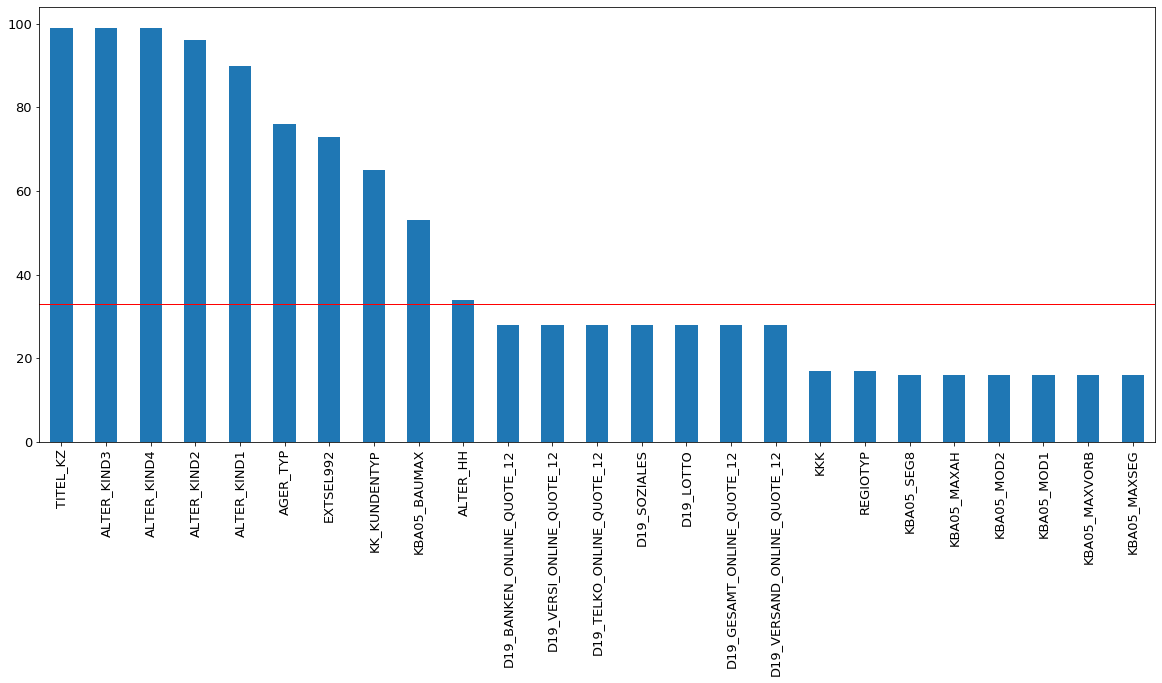

In [230]:
num_rows = 33
plt.axhline(y=num_rows,linewidth=1,color='r')
(null_counts.sort_values(ascending=False)[:25].plot(kind='bar', figsize=(20,8),fontsize=13))

The above graph shows the 25 features with the highest ratio of missing values (NaN).

I don't want to impute values for features with a high ratio of missing values because it will be inaccurate. 

For those features with over 1/3 of their values missing I am going to determine if there is another way to retain these features or whether they should just be dropped.

The features I need to analyse further are:

* TITEL_KZ
* ALTER_KIND*
* AGER_TYP
* EXTSEL992
* KK_KUNDENTYP
* KBA05_BAUMAX
* ALTER_HH

TITEL_KZ, ALTER_KIND, AGER_TYP can be min-max scaled with non-NaN values equal to 1 and NaN equal to -1. That indicates a 'have' and 'have not'

The following features are numerical features that wouldn't be when min-maxed scaled. With so many values missing I am going to drop them.

* EXTSEL992
* KK_KUNDENTYP
* KBA05_BAUMAX
* ALTER_HH

In [231]:
cols_to_drop = [
    'EXTSEL992',
    'KK_KUNDENTYP',
    'KBA05_BAUMAX',
    'ALTER_HH',
]

cols_to_drop_stage3 = [*cols_to_drop_stage2,*cols_to_drop]
cols_keep = [col for col in azdias.columns if col not in cols_to_drop_stage3]

print("Num Features to keep:{0}, Num Features to drop:{1}".format(len(cols_keep),len(cols_to_drop_stage3)))

Num Features to keep:337, Num Features to drop:29


In [232]:
Pickler.dump(cols_keep,'cols_keep')

In [233]:
azdias_clean = azdias_clean[cols_keep]

## Feature Engineering

Now that I have removed all bad features my next step is to engineer new features.

Summarising the discussion so far, here are the features that need engineering and what needs to happen:

* ARBEIT - One Hot Encode
* NATIONALITAET_KZ - One Hot Encode
* CAMEO_INTL_2015 - Split into two features

I will need to do this across datasets so I am going to write a function to do this.

In [248]:
def onehot_encode(series,*,min_value=0,max_value=1,verbosity=None):
    '''Take a pandas series and return a onehot encoded dataframe'''

    vp = VerbosityPrinter(verbosity)
    vp.low('Running onehot_encoder...')
    
    values = series.dropna().unique()
    
    vp.med(values)
    
    df = pd.DataFrame()
    for value in sorted(values):
        col_enc     = (f'{series.name}_{math.ceil(value)}')
        df[col_enc] = series.map(lambda x: max_value if x == value else min_value)
        
        vp.high(col_enc)
        
    vp.low('Finished onehot_encoder.')
    return(df)

In [252]:
arbeit_oh = onehot_encode(azdias_clean['ARBEIT'],verbosity=DEBUG)

Running onehot_encoder...
[3. 2. 4. 1. 5. 9.]
ARBEIT_1
ARBEIT_2
ARBEIT_3
ARBEIT_4
ARBEIT_5
ARBEIT_9
Finished onehot_encoder.


In [253]:
arbeit_oh.head(10)

,ARBEIT_1,ARBEIT_2,ARBEIT_3,ARBEIT_4,ARBEIT_5,ARBEIT_9
0,0,0,0,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0
5,0,1,0,0,0,0
6,0,0,0,1,0,0
7,0,1,0,0,0,0
8,0,1,0,0,0,0
9,0,1,0,0,0,0


In [270]:
def split_cameo_deuintl_2015(df_clean,verbosity):
    '''
    Split the CAEMO_DEUINTL_2015 feature into two.
    
    10,20,30,40,50 corresponds to wealth (W)
    1,2,3,4,5 corresponds to life stage (LS)
    
    Returns a dataframe of the two new features
    '''
    
    vp = VerbosityPrinter(verbosity)

    vp.low('Running split_cameo_deuintl_2015...')
    
    wealth_col = 'CAMEO_INTL_2015_W'
    life_stage_col = 'CAMEO_INTL_2015_LS'
    
    series = df_clean['CAMEO_INTL_2015'].copy()
    series = series.replace(['XX'],0)
    series = series.replace([np.NaN],0)
    series = series.astype(float)
    
    cameo_intl_df = pd.DataFrame()
    
    cameo_intl_df[wealth_col] = series.apply(lambda x: math.floor(x/10))
    cameo_intl_df[life_stage_col] = series.apply(lambda x: x % 10)
    
    cameo_intl_df[wealth_col] = cameo_intl_df[wealth_col].replace([0],np.NaN)
    cameo_intl_df[life_stage_col] = cameo_intl_df[life_stage_col].replace([0],np.NaN)
    
    df_clean = pd.concat([df_clean,cameo_intl_df],axis=1)
    df_clean = df_clean.drop('CAMEO_INTL_2015',axis=1)
    
    vp.low('Finished split_cameo_deuintl_2015...')
    
    return(df_clean)

In [255]:
azdias_clean = split_cameo_deuintl_2015(azdias_clean)

In [256]:
azdias_clean[['CAMEO_INTL_2015_W','CAMEO_INTL_2015_LS']].head(10)

,CAMEO_INTL_2015_W,CAMEO_INTL_2015_LS
0,NaN,NaN
1,5.0,1.0
2,2.0,4.0
3,1.0,2.0
4,4.0,3.0
5,5.0,4.0
6,2.0,2.0
7,1.0,4.0
8,1.0,3.0
9,1.0,5.0


In [267]:
def onehot_encode_df(df,verbosity):
    
    vp = VerbosityPrinter(verbosity)
    
    vp.low('Running onehot_encode_df...')
    
    fe_to_oh = ['ARBEIT','NATIONALITAET_KZ']
    
    for fe in fe_to_oh:
        if fe in df.columns:
            series_oh = onehot_encode(df[fe],verbosity=verbosity)
            df = pd.concat([df,series_oh],axis=1)
            df = df.drop(fe,axis=1)
    
    vp.low('Finished running onehot_encode_df...')
    
    return(df)

In [271]:
def clean_df(df,*,cols_keep=None,verbosity=NONE):

    vp = VerbosityPrinter(verbosity)
    
    vp.low('Running clean_df...')
    
    df_clean = df.copy()
    
    if cols_keep == None:
        cols_keep = Pickler.load('cols_keep')
 
    df_clean = df_clean[cols_keep]    
    df_clean = unknown_to_nan(df_clean,verbosity=verbosity)
    df_clean = onehot_encode_df(df_clean,verbosity=verbosity)
    df_clean = split_cameo_deuintl_2015(df_clean,verbosity=verbosity)

    vp.low('Finished running clean_df.')

    return(df_clean)

In [272]:
%%time
azdias_clean = clean_df(azdias,verbosity=LOW)

Running clean_df...
Running unknown_to_nan...
Finished unknown_to_nan...
Running onehot_encode_df...
Running onehot_encoder...
Finished onehot_encoder.
Running onehot_encoder...
Finished onehot_encoder.
Finished running onehot_encode_df...
Running split_cameo_deuintl_2015...
Finished split_cameo_deuintl_2015...
Finished running clean_df.
Wall time: 34.3 s


In [273]:
azdias_clean.shape

(891221, 345)

# Min and Max Scaling

I have created an updated version of azdias_analysis where I have updated the normalise_strat based on my prior analysis. I have done it this way to maintain continuity in the Notebook.

In [555]:
azdias_analysis = pd.read_csv('./analysis/azdias_analysis_updated.csv',sep=',',header=0)

In [556]:
azdias_analysis.loc[azdias_analysis.normalise_strat.isin(['MM'])]

,feature_name,in_dias,normalise_strat,uknown_v0,uknown_v1
0,AGER_TYP,True,MM,-1.0,NaN
2,ALTER_KIND1,False,MM,NaN,NaN
3,ALTER_KIND2,False,MM,NaN,NaN
4,ALTER_KIND3,False,MM,NaN,NaN
5,ALTER_KIND4,False,MM,NaN,NaN
87,DSL_FLAG,False,MM,NaN,NaN
103,GREEN_AVANTGARDE,True,MM,NaN,NaN
105,HH_DELTA_FLAG,False,MM,NaN,NaN
303,OST_WEST_KZ,True,MM,-1.0,NaN
331,SOHO_KZ,False,MM,-1.0,NaN


In [557]:
cols_mm = azdias_analysis.loc[azdias_analysis.normalise_strat.isin(['MM'])].feature_name.values

In [558]:
cols_mm = azdias_analysis.loc[azdias_analysis.normalise_strat.isin(['MM'])].feature_name.values

In [560]:
azdias_clean[cols_mm].shape

(891221, 14)

Cross referencing with the azdias_analysis sheet with the 'min' row above, I can see none of these features still have their 'uknown' values.

I have two Min-Max strategies. Some features I am setting NaN to -1 and not NaN to 1. For others I will need to impute a value.

Others are already either 1,0 or NaN. For these features I am going to set the 0 value to -1 and impute all NaN values.

In [562]:
cols_mm_to_nan = ['AGER_TYP','ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','TITEL_KZ',]
cols_mm_to_bin = ['DSL_FLAG','GREEN_AVANTGARDE','HH_DELTA_FLAG','OST_WEST_KZ','SOHO_KZ','UNGLEICHENN_FLAG','VERS_TYP','ANREDE_KZ']

In [563]:
assert ((len(cols_mm_to_nan)+len(cols_mm_to_bin)) == len(cols_mm))

In [565]:
azdias_clean[cols_mm_to_nan].head(5)

,AGER_TYP,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,TITEL_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
